In [1]:
import pickle
import datetime
from blockchain import blockexplorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dbFile = "simple_loop_process.dat"
timeFile = "times.txt"
timeDiffFile = "times_diff.txt"
actualTimeFile = "actual_times.txt"
blockchains = []
times = []
timeDiffs = []
actual_diffs = []
orphans = []
outliers = []

Reads data from the dbFile. This reads in blocks so we can manipulate them. The type of each block is simpleBlock from blockchain explorer.

In [3]:
def readData():
    with open(dbFile,"rb") as f:
        for _ in range(407908):
            try:
                blockchains.append(pickle.load(f))
            except:
                break

Writes the times to a file. Should only need to be done once, but whatever.

In [4]:
def writeTimes():
    with open(timeFile,"w") as f:
        for value in blockchains:
            f.write(str(value.time)+"\n")
            

Reads in the times from the timeFile.

In [5]:
def readTimes():
    global times
    times = [line.rstrip('\n') for line in open(timeFile)]

In [6]:
readData()

In [7]:
#check that we read in the blocks
len(blockchains)

401470

In [8]:
readTimes()

In [9]:
#check that we read in the times
len(times)

401470

This is a test block. Allows you to examine the timing and info about block. Ignore this as its lame

In [10]:
#print blockchains[0].time
#print blockchains[0].hash
#print blockchains[0].height
#print "########"
#print blockchains[1].time
#print blockchains[1].hash
#print blockchains[1].height
#print "########"
#print int(blockchains[0].time) - int(blockchains[1].time)
a = datetime.datetime.fromtimestamp(1460972535)
b = datetime.datetime.fromtimestamp(1460972545)
print type(a)
print b
#Mon, 18 Apr 2016 09:42:15 GMT
#Mon, 18 Apr 2016 09:42:25 GMT
#print type(blockchains[0].main_chain )
c =  a - b
print c.total_seconds()
print divmod(c.days * 86400 + c.seconds, 60)

<type 'datetime.datetime'>
2016-04-18 05:42:25
-10.0
(-1, 50)


Function that iterates over the times list and computes the difference between two times next to each other. Writes out to time_diff.txt. Reports the block height, time, and whether in main chain for each block as well as the time between each block. The last digit is seconds between blocks. Sample:
```
407864(1460995794,True) - 407863(1460992454,True)==> 0:55:40 ==>3340.0
```

In [11]:
def processTimes():
    global times
    global timeDiffs
    counter = 0
    f = open(timeDiffFile,"w")
    for i in range(len(times)):
        if i == len(times)-1:
            break
        #value = int(times[i]) - int(times[i+1])
        value = datetime.datetime.fromtimestamp(int(blockchains[i].time)) - datetime.datetime.fromtimestamp(int(blockchains[i+1].time))
        
        timeDiffs.append(value.total_seconds())
        f.write(str(counter)+": "+str(blockchains[i].height)+"("+str(blockchains[i].time)+","+str(blockchains[i].main_chain)+","+datetime.datetime.fromtimestamp(int(blockchains[i].time)).strftime('%Y-%m-%d %H:%M:%S')+")"+" - "+str(blockchains[i+1].height)+"("+str(blockchains[i+1].time)+","+str(blockchains[i+1].main_chain)+","+datetime.datetime.fromtimestamp(int(blockchains[i+1].time)).strftime('%Y-%m-%d %H:%M:%S')+")"+"==> "+str(value)+" ==>"+str(value.total_seconds())+"\n")
        counter += 1
    f.close()

In [12]:
processTimes()

In [13]:
#test that we have the right data
len(timeDiffs)

401469

In [14]:
timeDiffs[0]

1566.0

Function that converts unix time to human readable times and writes them to a file. Ignore this

In [15]:
def convertTimes():
    global times
    global actual_diffs
    f = open(actualTimeFile,"w")
    for value in times:
        value = datetime.datetime.fromtimestamp(int(value)).strftime('%Y-%m-%d %H:%M:%S')
        f.write(value+"\n")
    for value in timeDiffs:
        value2 = datetime.datetime.fromtimestamp(int(value)).strftime('%Y-%m-%d %H:%M:%S')
        actual_diffs.append(value2)
    f.close()

In [16]:
timeDiff_data = []
for value in timeDiffs:
    if value < 0:
        timeDiff_data.append(-1*value)
    else:
        timeDiff_data.append(value)

In [17]:
import matplotlib.pyplot as plt
def plot_data(seq):
    #plt.plot([1,2,3,4])
    plt.plot(timeDiff_data, seq)
    plt.ylabel('Time between blocks')
    plt.xlabel('Sequence')
    plt.show()

In [18]:
seq = []
for i in range(1,len(timeDiffs)+1):
    seq.append(i)

In [19]:
#plot_data(seq)
timeDiff_data[0]

1566.0

In [20]:
print len(timeDiff_data)
print len(seq)

401469
401469


In [21]:
def convertToMin(arr):
    for i in range(len(arr)):
        arr[i] = arr[i]/60
    return arr

In [22]:
del seq[-1]
del timeDiff_data[-1]
#df = pd.DataFrame({'index':seq[0:50],'time':timeDiff_data[0:50]})
df = pd.DataFrame({'index':seq[300:400],'time':convertToMin(timeDiff_data[300:400])})
print df.describe()

            index        time
count  100.000000  100.000000
mean   350.500000   10.148667
std     29.011492   10.249956
min    301.000000    0.233333
25%    325.750000    2.733333
50%    350.500000    6.700000
75%    375.250000   13.850000
max    400.000000   43.900000


In [23]:
#my_plot = df.plot(kind='bar')

In [24]:
print df.tail()

    index       time
95    396   0.233333
96    397   0.583333
97    398   4.933333
98    399  40.183333
99    400   7.066667


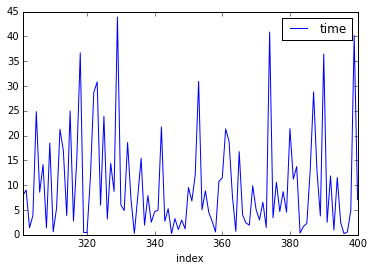

In [25]:
df.plot(kind='line',x='index',y='time')

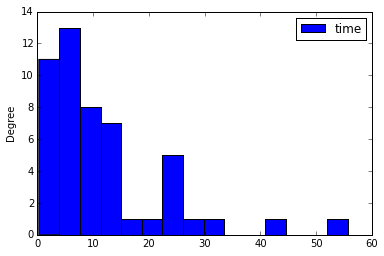

In [26]:
df2 = pd.DataFrame({'time':convertToMin(timeDiff_data[0:50])})
df2.plot(kind='hist',bins=15)

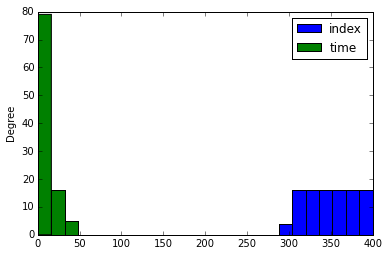

In [27]:
df.plot(kind='hist',bins=25)

In [28]:
def outlier(points,thresh=10):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [29]:
df3 = pd.DataFrame({'index':seq,'time':convertToMin(timeDiff_data)})

x = outlier(df3['time'])
len(x)

401468

In [46]:
def remove_outliers(df):
    temp = []
    x = outlier(df)
    for i in range(len(df)):
        if x[i] == True:
            print "Removing ",df[i]
        else:
            temp.append(df[i])
    return temp

In [31]:
new  = remove_outliers(df3['time'])

Removing  1490.38333333
Removing  2859.21666667
Removing  2840.0
Removing  2863.3
Removing  2873.83333333
Removing  2848.93333333
Removing  2856.26666667
Removing  2872.25
Removing  2873.71666667
Removing  2831.08333333
Removing  2860.68333333
Removing  2849.61666667
Removing  2867.15
Removing  2861.46666667
Removing  2854.6
Removing  78.3166666667
Removing  2875.45
Removing  2869.35
Removing  2866.96666667
Removing  2830.65
Removing  2864.13333333
Removing  2874.18333333
Removing  2874.31666667
Removing  2844.16666667
Removing  2826.8
Removing  2852.28333333
Removing  2871.78333333
Removing  2871.23333333
Removing  2876.83333333
Removing  2854.26666667
Removing  2859.01666667
Removing  2861.75
Removing  2868.66666667
Removing  2866.33333333
Removing  2863.76666667
Removing  2878.25
Removing  2923.85
Removing  83.6333333333
Removing  2917.9
Removing  2850.16666667
Removing  2857.71666667
Removing  2846.78333333
Removing  2873.15
Removing  2865.78333333
Removing  2838.03333333
Removing 

In [32]:
df4 = pd.DataFrame({'time':new})

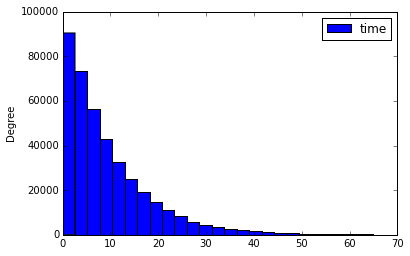

In [33]:
x = df4.plot(kind='hist',bins=25,range=[0, 65])

In [34]:
df4.describe()

,time
count,398356.000000
mean,9.573141
std,9.342171
min,0.000000
25%,2.883333
50%,6.750000
75%,13.266667
max,75.766667


In [35]:
df4.head()

,time
0,26.100000
1,8.816667
2,14.433333
3,10.766667
4,4.583333


In [36]:
bins = np.linspace(min(df4['time']),max(df4['time']),25)

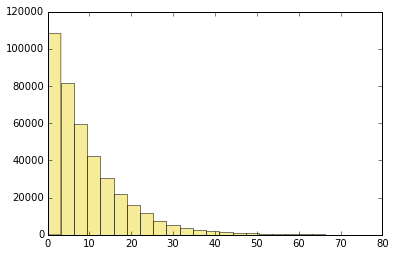

In [37]:
fig, ax = plt.subplots(1,1)
ax.hist(df4['time'],bins=bins,alpha=0.5,color='#EDD834')
#ax.set_xticks(bins[:-1])
plt.show()

In [38]:
def find_orphans():
    global orphans
    global blockchains
    orphans = []
    for i in blockchains:
        if i.main_chain == False:
            orphans.append(i)

In [39]:
len(orphans)

0

In [40]:
find_orphans()

In [41]:
len(orphans)

817

In [42]:
print orphans[0].time
print orphans[0].hash
print orphans[0].height

1460907019
00000000000000000307fce1866969b24cb465f98bf61519fbcc1f0dc05b0d80
407722


In [43]:
len(outliers)

3112